In [6]:
import bottleneck
import scipy.stats as stats
import numpy as np
import pandas as pd
#from calculate_auc import calc_auroc
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from lohia_utilities.create_corr_network import rank


def ml_hic(exp_upper= 0, exp_lower = 0 , resolution = 50, hi_c_percentile = 90, chrm = 10, file1= 'a', selected_feature = "all", keyword="", network_type=""):
    
        print (exp_upper, exp_lower)

        dist_folder = '/data/lohia/gene_distance_expresseion/agg_contact_map_ice_temp_2_comp/'
        principalDf = pd.read_hdf('%s/chrchr%s_resolution%s_entire_genes_comp.h5' %(dist_folder, chrm, resolution)) 

        gene_folder = '/data/lohia/gene_distance_expresseion/gene_tx_map'
        gene_file = "gencodev32_hg38_known_gene_chr%s_order.tsv" %chrm
        gene_data = pd.read_csv("%s/%s" %(gene_folder, gene_file), sep='\t',
                                header=0, index_col=None)
        gene_data.set_index('Gene stable ID', inplace=True)

        gene_data.drop(columns=['Gene type'], inplace = True)

        df_ncbi_gene_type_enseml = pd.read_csv('/data/lohia/gene_distance_expresseion/biomart_mapping_files/ENST_ENSG_NCBI_gene_type.txt', sep='\t') #this file has a lot of mapping, EntrezID, uniprot, Ensembl ID, genename
        df_ncbi_gene_type_enseml.drop_duplicates(subset=['Gene stable ID'], inplace=True)
        df_ncbi_gene_type_enseml.set_index('Gene stable ID', inplace=True)      

        gene_data =  gene_data.join(df_ncbi_gene_type_enseml['Gene type'], how='left')      

        gene_data['gene_type_reduced'] = [ 'protein' if 'protein' in x else 'mRNA' for x in gene_data['Gene type'].str.split('_')]

        df_exp_rank = pd.read_csv('/data/johlee/forRuchi/Homo_sapiens_average_rank.csv')

        df_exp_rank['genes'] = [x.split(".")[0] for x in df_exp_rank['genes']]
        df_exp_rank.drop_duplicates(subset=['genes'], inplace=True)     

        df_exp_rank.set_index('genes', inplace=True)
        df_exp_rank['exp_rank']= df_exp_rank.sum(axis=1)
        ranked_matirx = rank(df_exp_rank['exp_rank'])
        df_exp_rank['exp_rank'] = ranked_matirx     
        

        gene_data =  gene_data.join(df_exp_rank['exp_rank'], how='left') 
        gene_data['exp_rank'] = gene_data['exp_rank'].replace([np.nan], 0.5)

        gene_data['tss_bin'] = gene_data['txStart_outer']/ (resolution*1000)

        gene_data['tss_bin'] = gene_data['tss_bin'].astype('int')
        gene_data.reset_index(inplace=True)
        gene_data = gene_data.merge(right= principalDf, left_on='tss_bin', right_on=principalDf.index, how='left')
        
        gene_data.rename(columns={"Gene stable ID": "gene_data_id"}, inplace=True)


        #for network_type in ['VC_tss', 'VC_max']:
        #for network_type in ['hi-c-rao_nor_lib']:
        #for network_type in ['VC_lib_max', 'VC_max']:

         
        adj_tab = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/norm_dist_files/network_files_v2/network_%s_chr%s_resolution%s_hic_percentile%s_%s_entire_genes_degree.h5' %(network_type, chrm, resolution, hi_c_percentile, keyword))
        print (adj_tab.shape)
        print ("norm")
        print (adj_tab['exp'].max())
        
        adj_tab['exp_label'] = [1.0 if x > exp_upper else 0.0 if x < exp_lower else np.nan for x in adj_tab['exp']]
        
        print (adj_tab['exp_label'].max())
        
        adj_tab.dropna(subset=['exp_label'], inplace=True)  
        
        adj_tab = adj_tab[adj_tab['Gene stable ID_x'] != adj_tab['Gene stable ID_y']] 

        df1 = adj_tab.merge(right=gene_data, left_on='Gene stable ID_y', right_on='gene_data_id')
        adj_tab = df1.merge(right=gene_data, left_on='Gene stable ID_x', right_on='gene_data_id')

        # you will have to dropna with the given row property, compartment , gene type
        adj_tab.dropna(subset=['principal component 1_x', 'principal component 1_y', 'gene_type_reduced_x', 'gene_type_reduced_y', 'strand_y', 'strand_x'], inplace=True)  

        adj_tab['edge_compartment%s' %resolution]  = [0 if ( (x >=0) and (y>=0) ) else 1 if ( (x <0) and (y < 0) ) else 2 for x,y in zip(adj_tab['principal component 1_x'], adj_tab['principal component 1_y'])  ]

        adj_tab['gene_pair_type%s' %resolution]  = [0 if ( (x =='protein') and (y=='protein') ) else 1 if ( (x == 'mRNA') and (y == 'mRNA') ) else 2 for x,y in zip(adj_tab['gene_type_reduced_x'], adj_tab['gene_type_reduced_y'])  ]
        adj_tab['exp_mean%s' %resolution]  = (adj_tab['exp_rank_x'] + adj_tab['exp_rank_y'] )/2.0
        adj_tab['exp_diff%s' %resolution]  = adj_tab['exp_rank_x'] - adj_tab['exp_rank_y'] 
        adj_tab['exp_diff%s' %resolution] = adj_tab['exp_diff%s' %resolution].abs()
        
        adj_tab['strand_type%s' %resolution]  = [0 if ( (x =='+') and (y=='+') ) else 1 if ( (x == '-') and (y == '-') ) else 2 for x,y in zip(adj_tab['strand_y'], adj_tab['strand_x'])  ]
        
        adj_tab['gene_length_x'] =  adj_tab['txStart_outer_x'] - adj_tab['txEnd_outer_x']
        adj_tab['gene_length_y'] =  adj_tab['txStart_outer_y'] - adj_tab['txEnd_outer_y']
        

        adj_tab['avg_gene_length%s' %resolution]  = (adj_tab['gene_length_x'] + adj_tab['gene_length_y'] )/2.0

        adj_tab['diff_gene_length%s' %resolution]  = adj_tab['gene_length_x'] - adj_tab['gene_length_y']
        adj_tab['diff_gene_length%s' %resolution] = adj_tab['diff_gene_length%s' %resolution].abs()
        

        adj_tab['jac_denom%s' %resolution] = adj_tab['degreeGene stable ID_y'] + adj_tab['degreeGene stable ID_x'] - adj_tab['common_neighbors%s' %resolution]
        adj_tab['indirect_parameters%s' %resolution] = [np.inf if x==2 else 1.0/ (2.0*(x -2.0)) for x in adj_tab['shortest_path%s' %resolution]]
        
        print (adj_tab['exp_label'].to_numpy().sum())
        adj_tab.replace([np.inf], 100000000000, inplace=True)
        
        if selected_feature == "all":
        
            X = adj_tab[['jaccard_coefficient%s' %resolution , 'shortest_path%s' %resolution , 'clustering_avg_%s' %resolution , 'clustering_diff_%s' %resolution , 'closeness_centrality_avg_%s' %resolution , 'closeness_centrality_diff_%s' %resolution , 'betweenness_centrality_avg_%s' %resolution ,  'betweenness_centrality_diff_%s' %resolution ]].to_numpy()
        elif selected_feature == "CN_CA_CC":
        
            X = adj_tab[['common_neighbors%s' %resolution ,  'clustering_avg_%s' %resolution , 'closeness_centrality_avg_%s' %resolution ]].to_numpy()
        elif selected_feature == "CA_CC":
        
            X = adj_tab[['clustering_avg_%s' %resolution , 'closeness_centrality_avg_%s' %resolution ]].to_numpy()
        elif selected_feature == "CA_CN":
        
            X = adj_tab[['common_neighbors%s' %resolution ,  'clustering_avg_%s' %resolution ]].to_numpy()
        elif selected_feature == "CC_CN":
        
            X = adj_tab[['common_neighbors%s' %resolution , 'closeness_centrality_avg_%s' %resolution ]].to_numpy()
        elif selected_feature == "jaccard_coefficient":
            X = adj_tab[['jaccard_coefficient%s' %resolution]].to_numpy()
        else:
            X = adj_tab[['%s%s' %(selected_feature,resolution)]].to_numpy()
        print (X)
        
        Y = adj_tab['exp_label'].to_numpy()     
    
        print (adj_tab.shape)
        kf = KFold(n_splits=3, shuffle=True,random_state=1)
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1, activation='logistic', hidden_layer_sizes=(8,)) 

        predicted = []
        label = []
        accuracy = []
        for train_indices, test_indices in kf.split(X):
            print ("here")
            clf.fit(X[train_indices], Y[train_indices].ravel())
            predicted.append(clf.predict_proba(X[test_indices])[:,1].tolist())
            label.append(Y[test_indices].ravel().tolist())
            accuracy.append(clf.score(X[test_indices], Y[test_indices].ravel()))    

        auroc = []      

        for predicted_score, true_pos in zip(predicted, label):
            df = pd.DataFrame(predicted_score,columns=['predicted_score'])
            df['true_pos'] = true_pos
            df['true_neg'] = [0 if x==1 else 1 for x in df['true_pos']]
            auroc.append(calc_auroc(df,predicted_score='predicted_score'))
        print (sum(auroc) / len(auroc))

    
    #mean = sum(test_list) / len(test_list) 
    #variance = sum([((x - mean) ** 2) for x in test_list]) / len(test_list) 
    #res = variance ** 0.5
    #return (sum(auroc) / len(auroc), sum(accuracy) / len(accuracy), sum(adj_tab['exp_label'].to_list()) ,  len(adj_tab['exp_label'].to_list())   )

#if __name__ == '__main__':  #

#    chr_list = list(range(1,13)) + list(range(16,20)) +['X']
#    resolution_list = [50]
#    #chr_list = list(range(16,20)) +['X']
#    #chr_list = ['1']
#    #for resolution in [50, 100]:
#    #selected_feature = "all"
#    #selected_feature = "indirect_con"
#    #selected_feature = "tss_dist"
#    #selected_feature = "hic_link"
#    #for selected_feature in ['tss_dist', 'hic_link', 'all']:
#    #for selected_feature in ['jaccard_coefficient' , 'shortest_path' , 'clustering_avg_' , 'clustering_diff_' , 'closeness_centrality_avg_' , 'closeness_centrality_diff_' , 'betweenness_centrality_avg_' ,  'betweenness_centrality_diff_' ]:
#    #for network_type in ['VC_rank_tss', 'VC_lib_tss', 'VC_tss']:
#    for network_type in ['VC_tss']:
#        #for selected_feature in ['edge_compartment', 'gene_pair_type', 'exp_mean', 'exp_diff', 'jaccard_coefficient', 'jac_denom', 'common_neighbors', 'degree_avg_', 'degree_diff_',  'indirect_parameters', 'shortest_path' , 'clustering_avg_' , 'clustering_diff_' , 'closeness_centrality_avg_' , 'closeness_centrality_diff_' , 'betweenness_centrality_avg_' ,  'betweenness_centrality_diff_', 'all', 'CN_CA_CC', 'strand_type', 'avg_gene_length', 'diff_gene_length']:
#        for selected_feature in ["CA_CC", "CA_CN", "CC_CN" ]:
#        #for selected_feature in ['all']:
#            #for keyword in ["agg_temp_2", "agg_temp", "rao_kr", "rao_ice"]:
#            for keyword in ["agg_temp_2"]:
#                for resolution in resolution_list:
#                    
#                    df_2_or = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/norm_dist_files/combined_dist_%s_%s.h5' %(resolution, keyword)) # I don't need to load the entire file here
#                    df_2_or.dropna(subset=['exp'], inplace=True)  
#                    print (df_2_or['exp'].max())
#                    exp_upper = np.percentile(df_2_or[['exp']], 90)
#                    exp_lower = np.percentile(df_2_or[['exp']], 50)
#                    
#                    file1 = open("/data/lohia/gene_distance_expresseion/dist_files/RNN_hic_each_resol_v2_%s_%s_%s_%s_entire_genes_comp.txt" %(selected_feature, keyword, resolution, network_type),"w")
#                    for chrm in chr_list:
#                         ml_hic(exp_upper= exp_upper, exp_lower = exp_lower , resolution = resolution, hi_c_percentile = 90, chrm = chrm, file1=file1, selected_feature = selected_feature, keyword=keyword, network_type=network_type)
#                    file1.close()

In [13]:
!pip install -U seaborn

     |████████████████████████████████| 285 kB 9.3 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0


In [103]:
        exp_upper = 0.9113455493212599
        exp_lower =  0.5299280805628295
        resolution = 50
        hi_c_percentile = 90
        chrm = 18
        keyword="agg_temp_2"
        network_type="VC_lib_tss"

        print (exp_upper, exp_lower)

        dist_folder = '/data/lohia/gene_distance_expresseion/agg_contact_map_ice_temp_2_comp/'
        principalDf = pd.read_hdf('%s/chrchr%s_resolution%s_entire_genes_comp.h5' %(dist_folder, chrm, resolution)) 

        gene_folder = '/data/lohia/gene_distance_expresseion/gene_tx_map'
        gene_file = "gencodev32_hg38_known_gene_chr%s_order.tsv" %chrm
        gene_data = pd.read_csv("%s/%s" %(gene_folder, gene_file), sep='\t',
                                header=0, index_col=None)
        gene_data.set_index('Gene stable ID', inplace=True)

        gene_data.drop(columns=['Gene type'], inplace = True)

        df_ncbi_gene_type_enseml = pd.read_csv('/data/lohia/gene_distance_expresseion/biomart_mapping_files/ENST_ENSG_NCBI_gene_type.txt', sep='\t') #this file has a lot of mapping, EntrezID, uniprot, Ensembl ID, genename
        df_ncbi_gene_type_enseml.drop_duplicates(subset=['Gene stable ID'], inplace=True)
        df_ncbi_gene_type_enseml.set_index('Gene stable ID', inplace=True)      

        gene_data =  gene_data.join(df_ncbi_gene_type_enseml['Gene type'], how='left')      

        gene_data['gene_type_reduced'] = [ 'protein' if 'protein' in x else 'mRNA' for x in gene_data['Gene type'].str.split('_')]

        df_exp_rank = pd.read_csv('/data/johlee/forRuchi/Homo_sapiens_average_rank.csv')

        df_exp_rank['genes'] = [x.split(".")[0] for x in df_exp_rank['genes']]
        df_exp_rank.drop_duplicates(subset=['genes'], inplace=True)     

        df_exp_rank.set_index('genes', inplace=True)
        df_exp_rank['exp_rank']= df_exp_rank.sum(axis=1)
        ranked_matirx = rank(df_exp_rank['exp_rank'])
        df_exp_rank['exp_rank'] = ranked_matirx     
        

        gene_data =  gene_data.join(df_exp_rank['exp_rank'], how='left') 
        gene_data['exp_rank'] = gene_data['exp_rank'].replace([np.nan], 0.5)

        gene_data['tss_bin'] = gene_data['txStart_outer']/ (resolution*1000)

        gene_data['tss_bin'] = gene_data['tss_bin'].astype('int')
        gene_data.reset_index(inplace=True)
        gene_data = gene_data.merge(right= principalDf, left_on='tss_bin', right_on=principalDf.index, how='left')
        
        gene_data.rename(columns={"Gene stable ID": "gene_data_id"}, inplace=True)


        #for network_type in ['VC_tss', 'VC_max']:
        #for network_type in ['hi-c-rao_nor_lib']:
        #for network_type in ['VC_lib_max', 'VC_max']:

         
        adj_tab = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/norm_dist_files/network_files_v2/network_%s_chr%s_resolution%s_hic_percentile%s_%s_entire_genes_degree.h5' %(network_type, chrm, resolution, hi_c_percentile, keyword))
        print (adj_tab.shape)
        print ("norm")
        print (adj_tab['exp'].max())
        
        adj_tab['exp_label'] = [1.0 if x > exp_upper else 0.0 if x < exp_lower else np.nan for x in adj_tab['exp']]
        
        print (adj_tab['exp_label'].max())
        
        adj_tab.dropna(subset=['exp_label'], inplace=True)  
        
        adj_tab = adj_tab[adj_tab['Gene stable ID_x'] != adj_tab['Gene stable ID_y']] 

        df1 = adj_tab.merge(right=gene_data, left_on='Gene stable ID_y', right_on='gene_data_id')
        adj_tab = df1.merge(right=gene_data, left_on='Gene stable ID_x', right_on='gene_data_id')

        # you will have to dropna with the given row property, compartment , gene type
        adj_tab.dropna(subset=['principal component 1_x', 'principal component 1_y', 'gene_type_reduced_x', 'gene_type_reduced_y', 'strand_y', 'strand_x'], inplace=True)  

        adj_tab['edge_compartment%s' %resolution]  = [0 if ( (x >=0) and (y>=0) ) else 1 if ( (x <0) and (y < 0) ) else 2 for x,y in zip(adj_tab['principal component 1_x'], adj_tab['principal component 1_y'])  ]

        adj_tab['gene_pair_type%s' %resolution]  = [0 if ( (x =='protein') and (y=='protein') ) else 1 if ( (x == 'mRNA') and (y == 'mRNA') ) else 2 for x,y in zip(adj_tab['gene_type_reduced_x'], adj_tab['gene_type_reduced_y'])  ]
        adj_tab['exp_mean%s' %resolution]  = (adj_tab['exp_rank_x'] + adj_tab['exp_rank_y'] )/2.0
        adj_tab['exp_diff%s' %resolution]  = adj_tab['exp_rank_x'] - adj_tab['exp_rank_y'] 
        adj_tab['exp_diff%s' %resolution] = adj_tab['exp_diff%s' %resolution].abs()
        
        adj_tab['strand_type%s' %resolution]  = [0 if ( (x =='+') and (y=='+') ) else 1 if ( (x == '-') and (y == '-') ) else 2 for x,y in zip(adj_tab['strand_y'], adj_tab['strand_x'])  ]
        
        adj_tab['gene_length_x'] =  adj_tab['txStart_outer_x'] - adj_tab['txEnd_outer_x']
        adj_tab['gene_length_y'] =  adj_tab['txStart_outer_y'] - adj_tab['txEnd_outer_y']
        

        adj_tab['avg_gene_length%s' %resolution]  = (adj_tab['gene_length_x'] + adj_tab['gene_length_y'] )/2.0

        adj_tab['diff_gene_length%s' %resolution]  = adj_tab['gene_length_x'] - adj_tab['gene_length_y']
        adj_tab['diff_gene_length%s' %resolution] = adj_tab['diff_gene_length%s' %resolution].abs()
        

        adj_tab['jac_denom%s' %resolution] = adj_tab['degreeGene stable ID_y'] + adj_tab['degreeGene stable ID_x'] - adj_tab['common_neighbors%s' %resolution]
        adj_tab['indirect_parameters%s' %resolution] = [np.inf if x==2 else 1.0/ (2.0*(x -2.0)) for x in adj_tab['shortest_path%s' %resolution]]
        
        print (adj_tab['exp_label'].to_numpy().sum())
        adj_tab.replace([np.inf], 100, inplace=True)

0.9113455493212599 0.5299280805628295
(115325, 26)
norm
0.9999480257420199
1.0
6351.0


In [95]:
adj_tab_nodes = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/norm_dist_files/network_files_v2/network_%s_chr%s_resolution%s_hic_percentile%s_%s_entire_genes_degree.h5' %(network_type, chrm, resolution, hi_c_percentile, keyword))

In [100]:
adj_tab_nodes['hi-c-rao_nor_lib-90'].sum()

2433579

In [8]:
adj_tab.columns

Index(['Gene stable ID_y', 'Gene stable ID_x', 'exp', 'VC_lib_tss', 'tss_tss',
       'hi-c-rao_nor_lib-90', 'dropping_unexpressed', 'jaccard_coefficient50',
       'shortest_path50', 'common_neighbors50', 'clusteringGene stable ID_y',
       'clusteringGene stable ID_x', 'clustering_avg_50', 'clustering_diff_50',
       'closeness_centralityGene stable ID_y',
       'closeness_centralityGene stable ID_x', 'closeness_centrality_avg_50',
       'closeness_centrality_diff_50',
       'betweenness_centralityGene stable ID_y',
       'betweenness_centralityGene stable ID_x',
       'betweenness_centrality_avg_50', 'betweenness_centrality_diff_50',
       'degreeGene stable ID_y', 'degreeGene stable ID_x', 'degree_avg_50',
       'degree_diff_50', 'exp_label', 'gene_data_id_x', 'strand_x',
       'txStart_outer_x', 'txEnd_outer_x', 'gene_order_tss_x',
       'gene_order_tes_x', 'UniProtKB/Swiss-Prot ID_x',
       'UniProtKB/TrEMBL ID_x', 'Uniprot_dc_x', 'dc_x', 'seq_length_x',
       'chrom

In [101]:
z = list(set(adj_tab_nodes['Gene stable ID_y'].to_list() + adj_tab_nodes['Gene stable ID_x'].to_list() ))

In [102]:
len(z)

5247

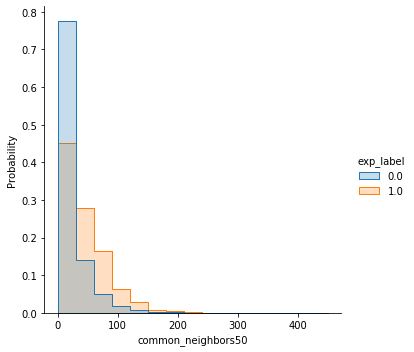

In [76]:
import seaborn as sns
ax = sns.displot(data=adj_tab, x="common_neighbors50", hue="exp_label", kind="hist", stat="probability", binwidth=30, element="step", common_norm=False)
#ax.set(ylim=(0, 0.05))
#ax.set(xlim=(0, 300.0))

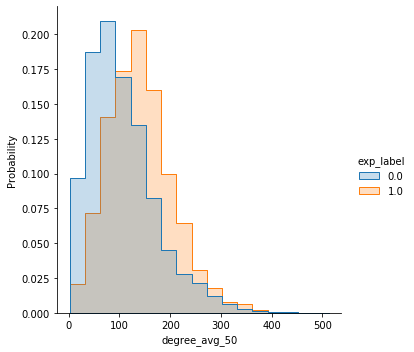

In [104]:
import seaborn as sns
ax = sns.displot(data=adj_tab, x="degree_avg_50", hue="exp_label", kind="hist", stat="probability", binwidth=30, element="step", common_norm=False)

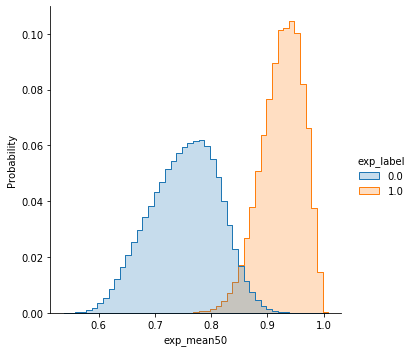

In [45]:
import seaborn as sns
ax = sns.displot(data=adj_tab, x="exp_mean50", hue="exp_label", kind="hist", stat="probability", binwidth=0.01, element="step", common_norm=False)
#ax.set(ylim=(0, 0.05))
#ax.set(xlim=(0, 300.0))

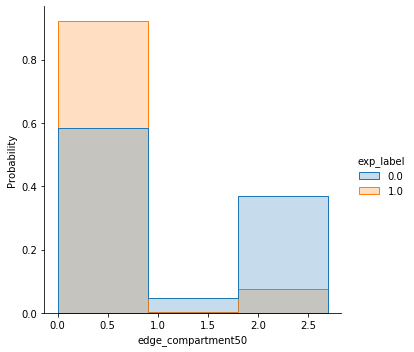

In [81]:
import seaborn as sns
ax = sns.displot(data=adj_tab, x="edge_compartment50", hue="exp_label", kind="hist", stat="probability", binwidth=0.9, element="step", common_norm=False)

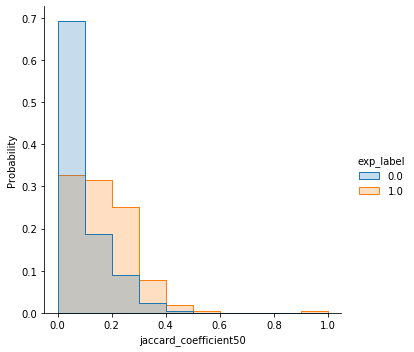

In [82]:
import seaborn as sns
ax = sns.displot(data=adj_tab, x="jaccard_coefficient50", hue="exp_label", kind="hist", stat="probability", binwidth=0.1, element="step", common_norm=False)
#ax.set(ylim=(0, 0.05))
#ax.set(xlim=(0, 300.0))

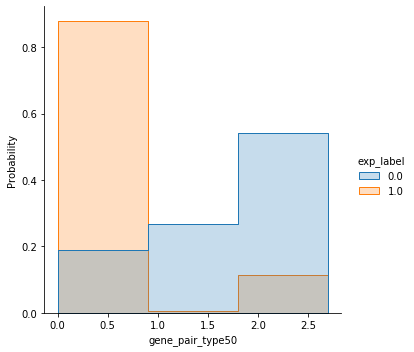

In [83]:
import seaborn as sns
ax = sns.displot(data=adj_tab, x="gene_pair_type50", hue="exp_label", kind="hist", stat="probability", binwidth=0.9, element="step", common_norm=False)


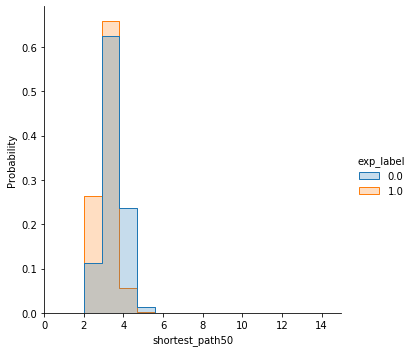

In [86]:
import seaborn as sns
ax = sns.displot(data=adj_tab, x="shortest_path50", hue="exp_label", kind="hist", stat="probability", element="step", binwidth=0.9, common_norm=False)
ax.set(xlim=(0, 15.0))

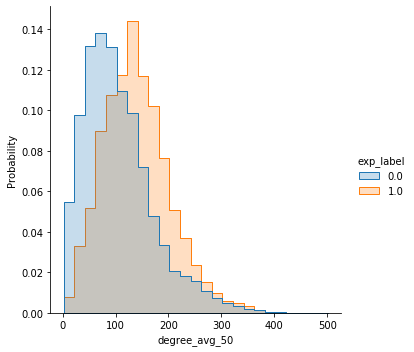

In [85]:
import seaborn as sns
adj_tab.replace(50, 20, inplace=True)
ax = sns.displot(data=adj_tab, x="degree_avg_50", hue="exp_label", kind="hist", stat="probability", element="step", binwidth=20, common_norm=False)